In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.1


## Utility Functions

In [2]:
# Make cluster by cluster plots
def plot_by_cluster(adata, clust_key, size=60, legend_loc=None, **kwargs):
    tmp = adata.copy()

    for i,clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype('category')
        tmp.uns[clust+'_colors'] = ['#d3d3d3', adata.uns[clust_key+'_colors'][i]]

    sc.pl.umap(tmp, groups=tmp.obs[clust].cat.categories[1:].values, color=adata.obs[clust_key].cat.categories.tolist(), size=size, legend_loc=legend_loc, **kwargs)

In [3]:
# Map annotations to abbreviated names
def annotation_abbr(annotations):
    tmp = []
    for ann in annotations:
        ann = ann.replace('Natural killer T (NKT) cell','NKT')
        ann = ann.replace('Hematopoietic stem cell','HSC')
        ann = ann.replace('Mesenchymal stem cell','MSC')
        ann = ann.replace('Natural killer cell','NK')
        ann = ann.replace('Embryonic stem cell','ESC')
        ann = ann.replace('Regulatory T (Treg) cell', 'Treg')
        ann = ann.replace(' (Th1)','')
        ann = ann.replace('T helper', 'Th')
        ann = ann.replace(' cell','')
        ann = ann.replace('-','UND')
        tmp.append(ann)
    return tmp

In [4]:
def names_make_unique(annotations):
    ann_dic = {}
    # construct dictionary for all names, cluster indices will be stored for each name
    for i,ann in enumerate(annotations):
        if ann_dic.get(ann)==None:
            ann_dic[ann] = [i]
        else:
            ann_dic[ann].append(i)
    #  
    for ann in ann_dic:
        num = len(ann_dic[ann])
        if num > 1:
            for indx in ann_dic[ann]:
                annotations[indx] = '('+ann+')'+'_'+ str(num)
                num -= 1
    return annotations

## Automated Annotation

#### We use SCSA to help annotate the clusters. SCSA annotation is based on a few manually curated database. Instructions can be found https://github.com/bioinfo-ibms-pumc/SCSA.

In [5]:
%%bash

cd /SCSA
python3 SCSA.py -d whole.db -i /scratch/umap_cluster.csv -s scanpy -E -f1.5 -p 0.01 -o /scratch/umap_annotation_result -m txt 

DB load: 47347 3 3 48257 37440
Namespace(Gensymbol=True, MarkerDB=None, celltype='normal', cluster='all', db='whole.db', foldchange=1.5, input='/scratch/umap_cluster.csv', list_tissue=False, noprint=False, norefdb=False, outfmt='txt', output='/scratch/umap_annotation_result', pvalue=0.01, source='scanpy', species='Human', target='cellmarker', tissue='All', weight=100.0)
DB load: 47347 3 3 48257 37440
load markers: 45409
############################## Cluster 0 ##############################

Cell Num: 6
Gene Num: 4
Not Zero: 10
Cluster 0 Gene number: 8
------------------------------------------------------------
Type                Cell Type           Score     Times
------------------------------------------------------------
Good             Microglial cell        2.0372    6.9  
------------------------------------------------------------

Go Enrichment analysis: Group1: 4 Group2: 1260
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Function <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        ids  gene_num  othe

## Loading projection coordinates and cluster annotations

In [5]:
combined_umap = sc.read('/scratch/combined_umap.h5ad')

In [7]:
# copy and paste the raw output for umap
umap_annotation_output=[['0', 'Good', 'Microglial cell', 2.0372203013610175, 6.884191535115531],
['1', 'Good', 'B cell', 10.29697694501417, 8.023297061461406],
['10', '?', 'T cell|Natural killer cell', '7.780536294829138|4.231026529444835', 1.8389240154091033],
['11', 'Good', 'Microglial cell', 4.639823507498554, 2.8192638901197764],
['12', '?', 'Natural killer cell|T cell', '3.0204602097926725|1.5777166814981063', 1.914450322553871],
['13', '?', 'Microglial cell|T cell', '3.6853989084655563|2.143971297922327', 1.7189590700383868],
['14', '?', 'Microglial cell|Natural killer cell', '3.0633895510636724|2.1982729625433035', 1.3935437515091245],
['15', '?', 'Natural killer T (NKT) cell|T cell', '5.263509679582449|4.363523035594667', 1.206252295827546],
['16', '?', 'T cell|Natural killer T (NKT) cell', '6.613948585855852|4.923518033079796', 1.3433379427918222],
['17', '?', 'Mesenchymal stem cell|Stem cell', '7.54289930124478|4.027657304976333', 1.8727758421564873],
['18', '?', 'T cell|Natural killer cell', '8.075256730689164|4.441129854578116', 1.8182888127814651],
['19', 'Good', 'Basal cell', 8.876690330803893, 2.5519477275331632],
['2', '?', 'Natural killer T (NKT) cell|T helper cell', '4.721656177797972|3.413278796296955', 1.3833198105353912],
['20', '?', 'Natural killer cell|T cell', '4.316562361262539|3.0013249287344057', 1.4382189412203166],
['21', '?', 'Regulatory T (Treg) cell|T cell', '8.283776395121333|5.795733313976942', 1.4292887450746306],
['22', '?', 'T cell|Follicular helper (Tfh) T cell', '5.21117618041307|3.7233021076147015', 1.3996114281877496],
['23', 'N', '-', '-', '-'],
['24', '?', 'T cell|Natural killer cell', '5.827064806985637|5.197693259224418', 1.1210867044999748],
['25', 'Good', 'Follicular helper (Tfh) T cell', 4.78143800445443, 2.123317061274468],
['26', '?', 'Astrocyte|Natural killer T (NKT) cell', '4.129859422871909|3.526236845685343', 1.1711803839623394],
['27', '?', 'Endothelial cell|Mesenchymal stem cell', '9.645431609503447|5.360872284055056', 1.7992280170881962],
['28', '?', 'Stem cell|Progenitor cell', '6.7769558939739625|3.8796575777560403', 1.74679227693432],
['29', 'Good', 'B cell', 8.178405241130532, 2.6097902580195362],
['3', '?', 'T cell|Natural killer cell', '6.360976627391617|4.784085862455552', 1.3296117189934142],
['30', '?', 'Natural killer T (NKT) cell|Hematopoietic stem cell', '6.979633061105793|3.7487275868654852', 1.8618672334475612],
['31', 'Good', 'Microglial cell', 5.452339376055571, 2.0601741855056344],
['32', '?', 'Mast cell|Hematopoietic stem cell', '7.31098292723881|4.556511508732889', 1.6045132143805134],
['33', 'Good', 'B cell', 9.904895864034916, 6.749506285201575],
['34', '?', 'Natural killer cell|Microglial cell', '4.18499539754487|3.5093950820603537', 1.1925119001101105],
['35', '?', 'T cell|Natural killer T (NKT) cell', '6.495987437886226|5.136026808779065', 1.2647884599789405],
['36', '?', 'Follicular helper (Tfh) T cell|Natural killer cell', '7.04922372026415|3.9241683104597316', 1.7963612063923695],
['4', 'Good', 'B cell', 9.131910949132633, 2.195399796684948],
['5', '?', 'Microglial cell|Hematopoietic stem cell', '4.701313473685622|3.4233186833243647', 1.3733204263414367],
['6', '?', 'Basal cell|Embryonic stem cell', '5.764133887291763|4.511769522938633', 1.2775772029102745],
['7', '?', 'Natural killer T (NKT) cell|Natural killer cell', '4.664288291028641|4.4392964281657346', 1.0506818741446087],
['8', 'Good', 'Natural killer cell', 8.383403065982082, 2.047747874286124],
['9', 'Good', 'Follicular helper (Tfh) T cell', 0.7071067811865477, 1.0000000000000002]]


# extract annotations
umap_cluster_names = [None for _ in range(len(umap_annotation_output))]
for annotation in umap_annotation_output:
    index = int(annotation[0])
    name = annotation[2]
    umap_cluster_names[index] = name

# Unannotated UMAP plot with Marker Genes

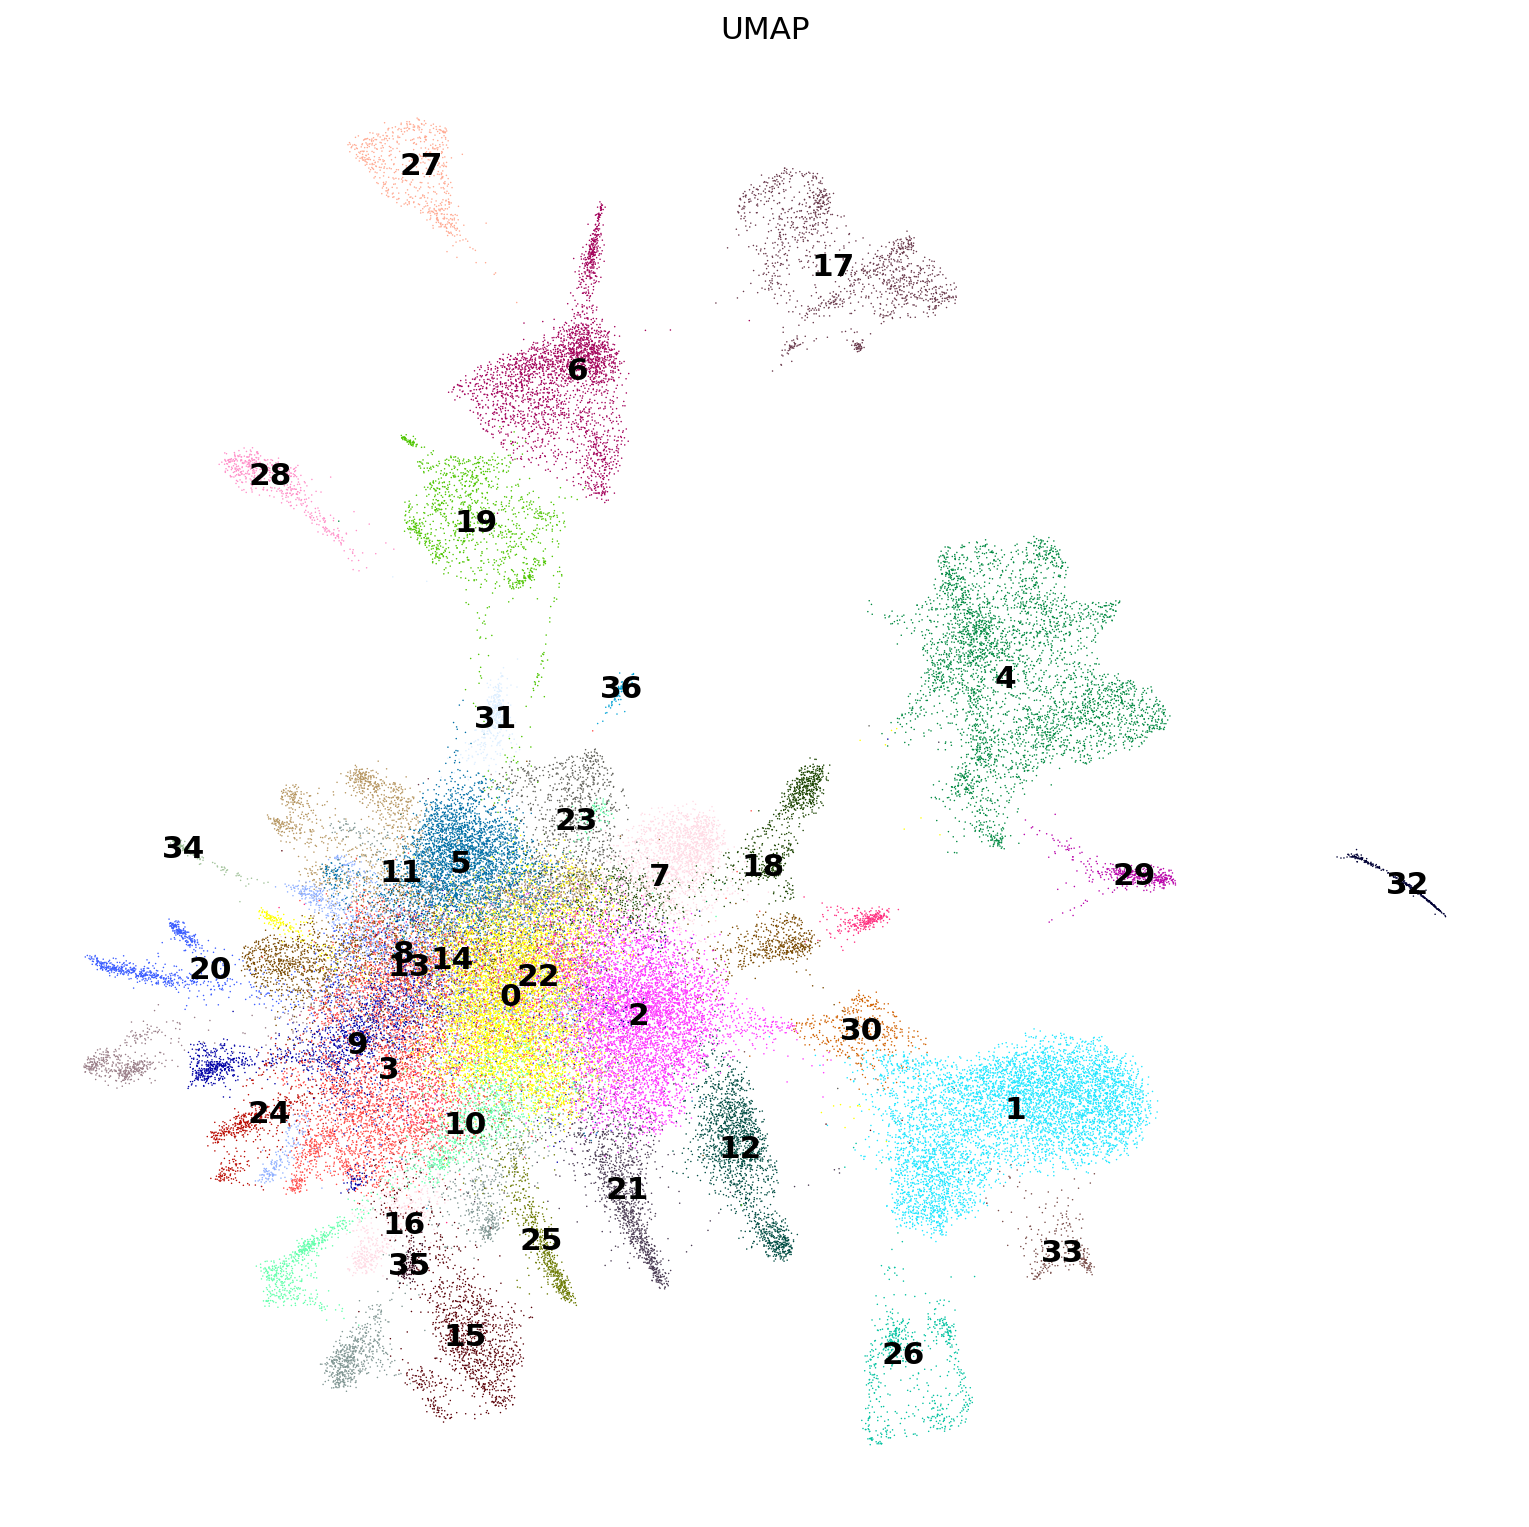

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
sc.pl.umap(combined_umap, color='leiden', title='UMAP', legend_loc='on data',frameon=False,ax=ax)

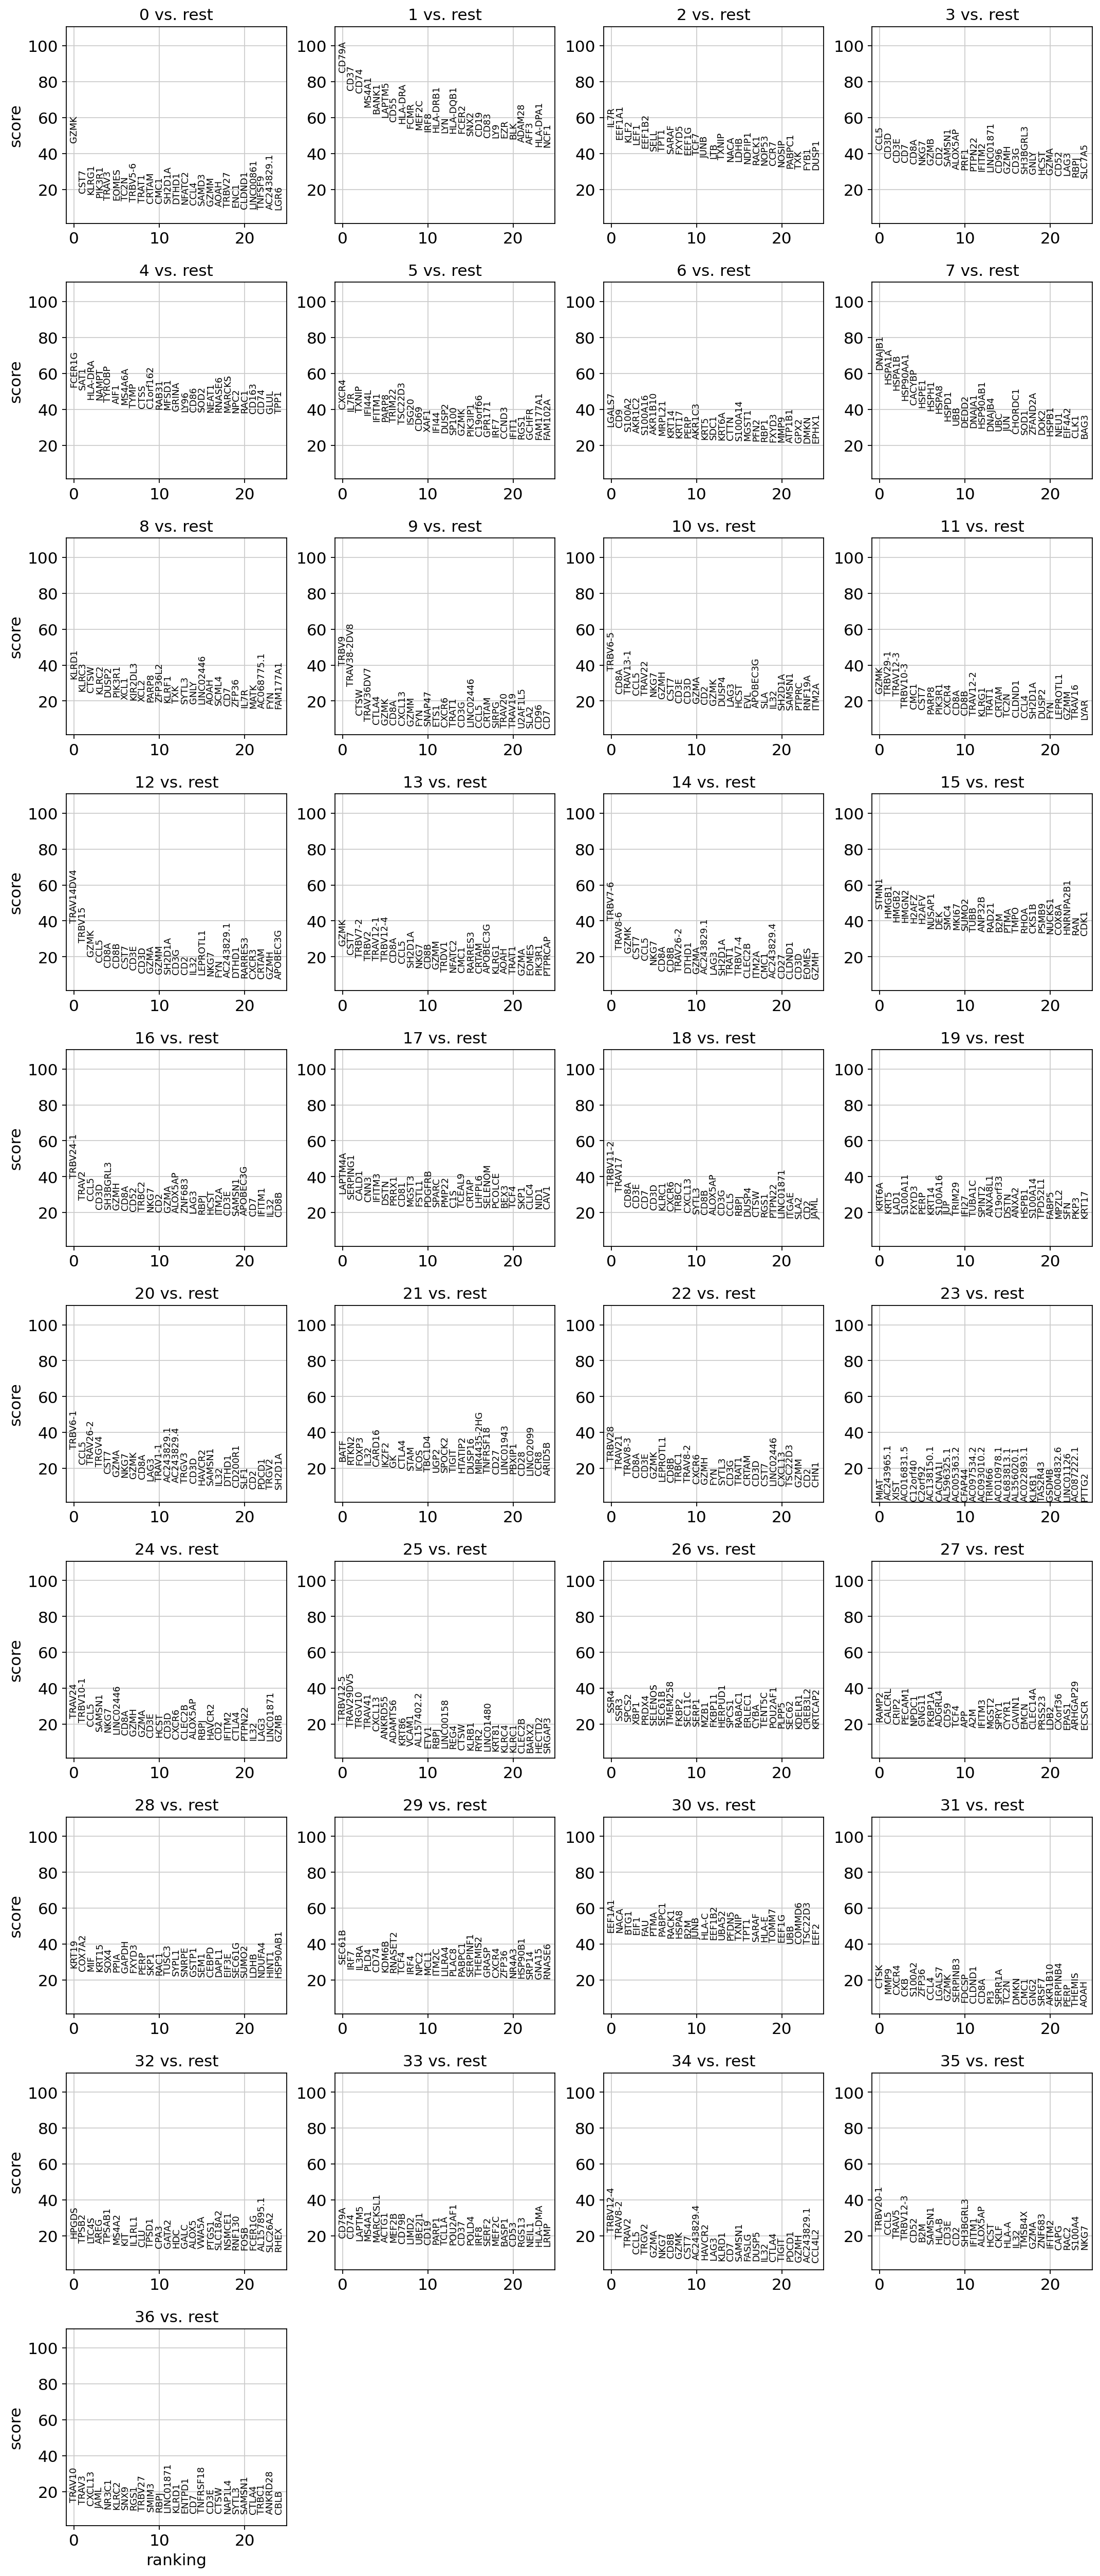

In [7]:
sc.pl.rank_genes_groups(combined_umap,n_genes=25)

# Automatic Annotations on Clusters
#### Note that here the genes are selected based on gene score which leverages both adjusted p-value and log-fold-change. Since all the p-values for top 5 genes do not have any numerical significance (below machine limit), we don't list them here.

(0, '(Microglial)_3')
(1, '(B)_4')
(2, 'NKT|Th')
(3, '(T|NK)_4')
(4, '(B)_3')
(5, 'Microglial|HSC')
(6, 'Basal|ESC')
(7, 'NKT|NK')
(8, 'NK')
(9, '(Follicular helper (Tfh) T)_2')
(10, '(T|NK)_3')
(11, '(Microglial)_2')
(12, '(NK|T)_2')
(13, 'Microglial|T')
(14, 'Microglial|NK')
(15, 'NKT|T')
(16, '(T|NKT)_2')
(17, 'MSC|Stem')
(18, '(T|NK)_2')
(19, 'Basal')
(20, '(NK|T)_1')
(21, 'Treg|T')
(22, 'T|Follicular helper (Tfh) T')
(23, 'UND')
(24, '(T|NK)_1')
(25, '(Follicular helper (Tfh) T)_1')
(26, 'Astrocyte|NKT')
(27, 'Endothelial|MSC')
(28, 'Stem|Progenitor')
(29, '(B)_2')
(30, 'NKT|HSC')
(31, '(Microglial)_1')
(32, 'Mast|HSC')
(33, '(B)_1')
(34, 'NK|Microglial')
(35, '(T|NKT)_1')
(36, 'Follicular helper (Tfh) T|NK')


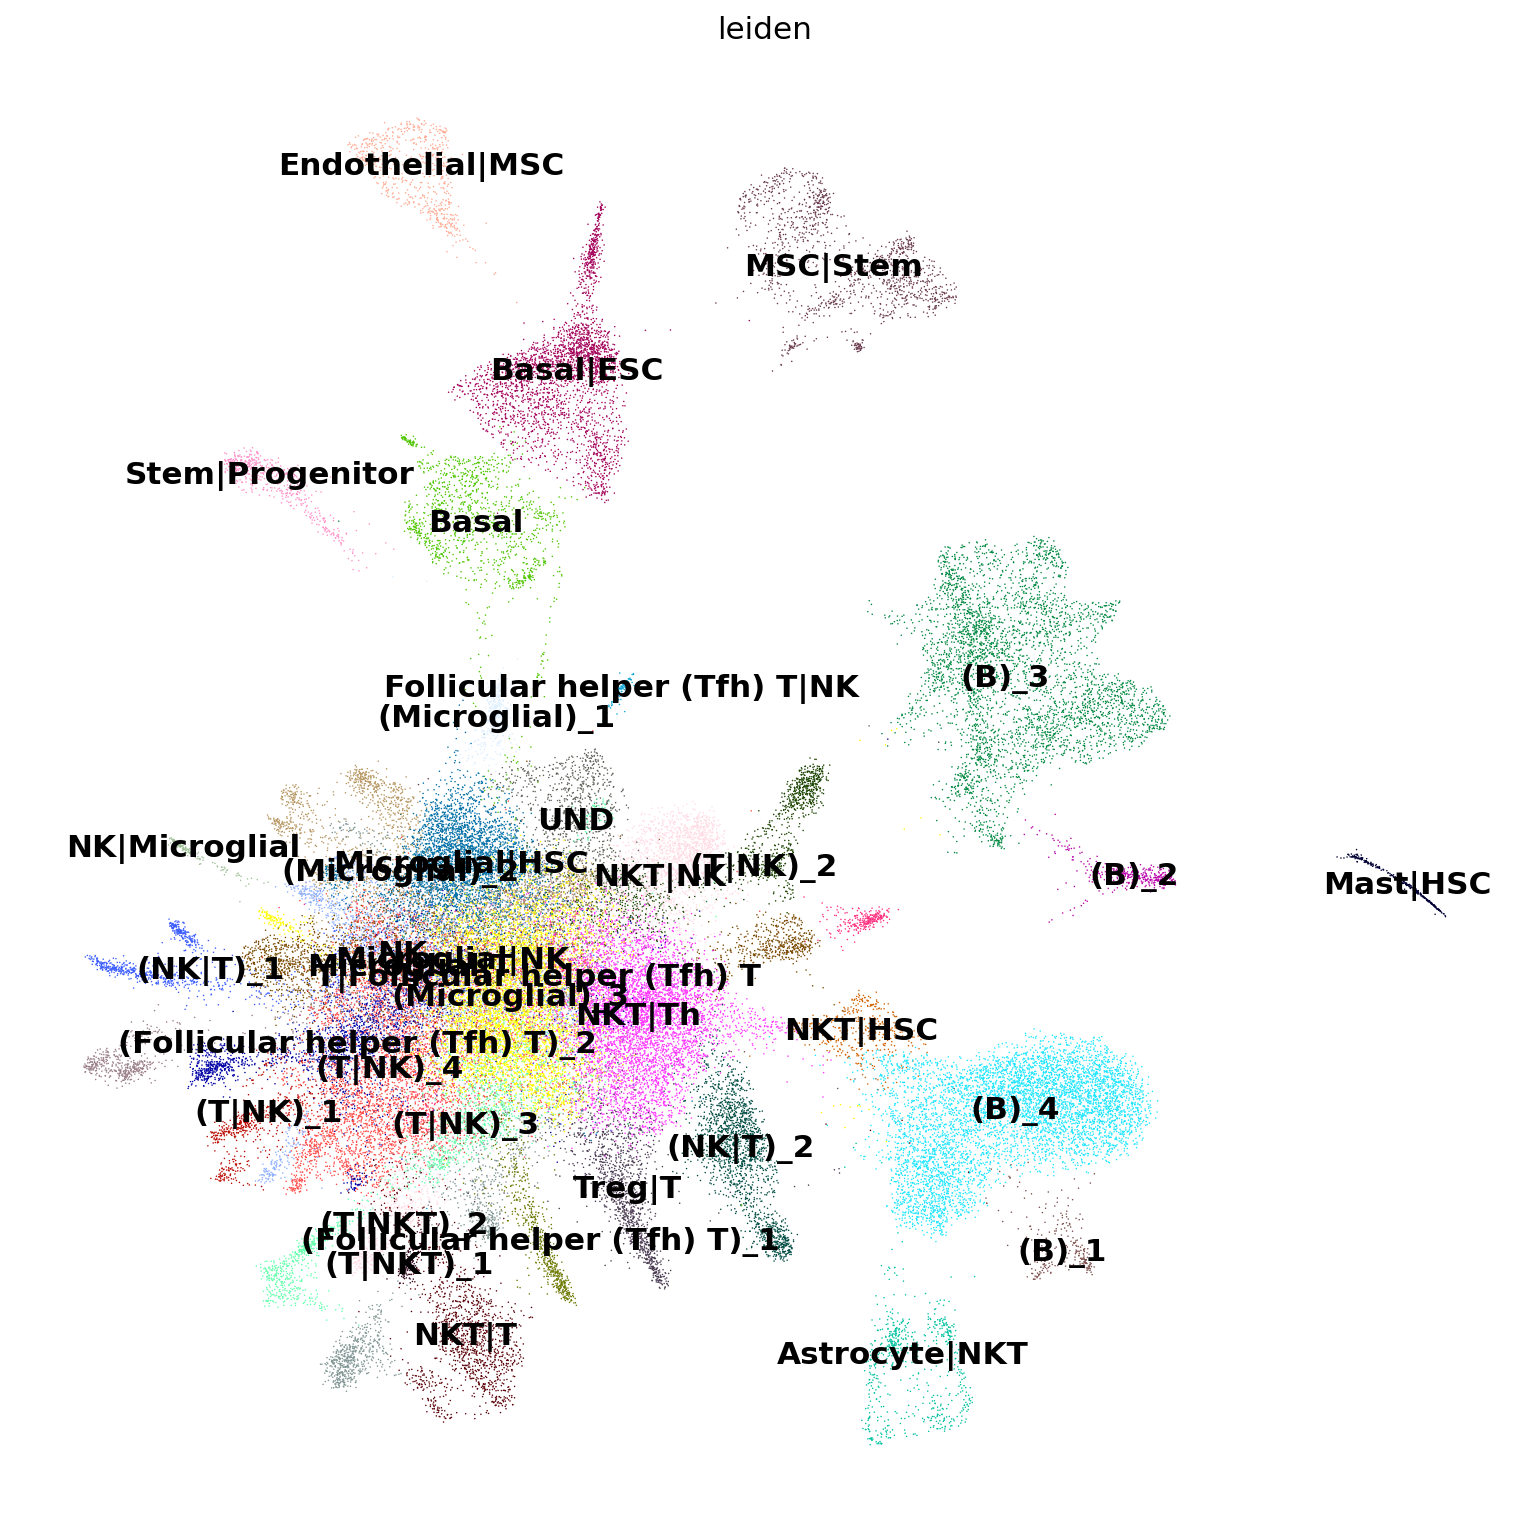

In [10]:
umap_cluster_names = annotation_abbr(umap_cluster_names)
umap_cluster_names = names_make_unique(umap_cluster_names)
# View cluster annotations and get the number of labels that needs extra attention
for i,name in enumerate(umap_cluster_names):
    print((i,name))

combined_umap.rename_categories('leiden', umap_cluster_names)
fig, ax = plt.subplots(figsize=(12,12))
sc.pl.umap(combined_umap, color='leiden',legend_loc='on data',frameon=False,ax=ax)

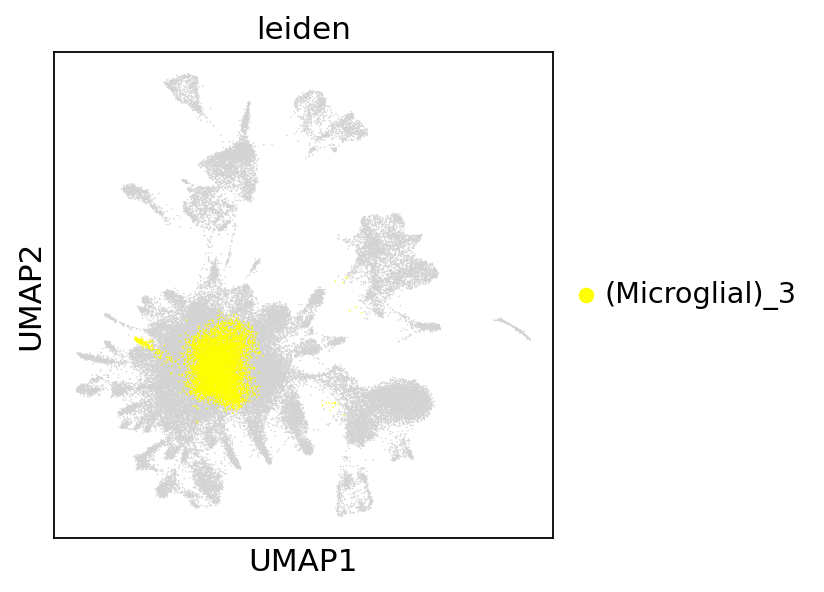

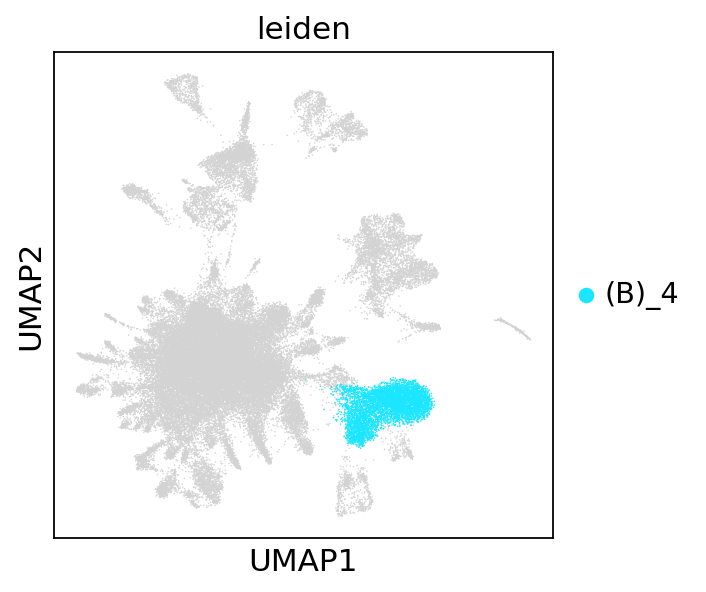

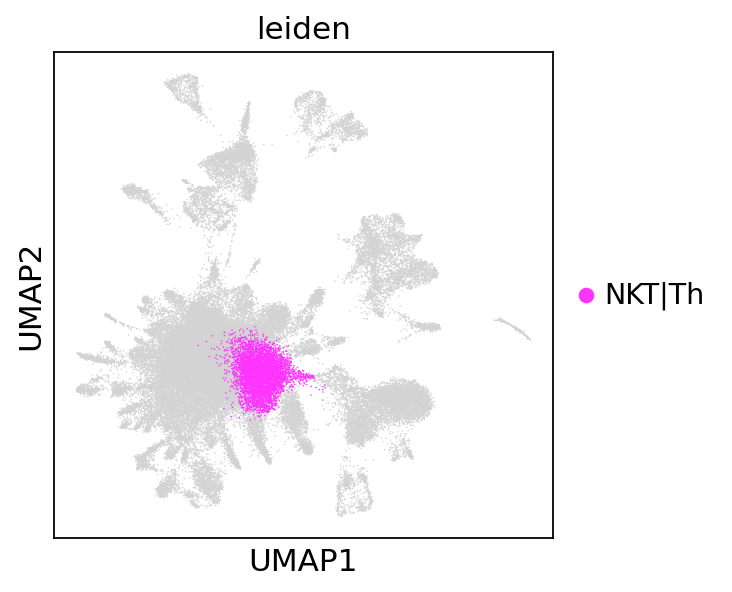

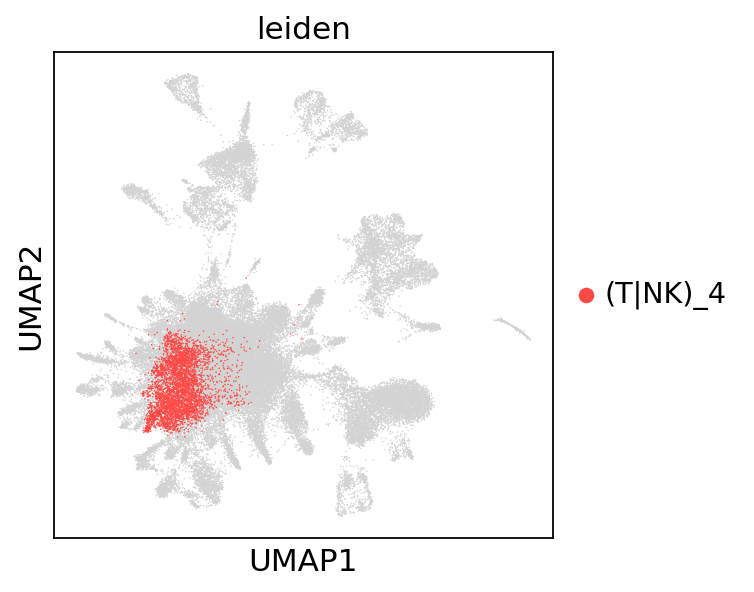

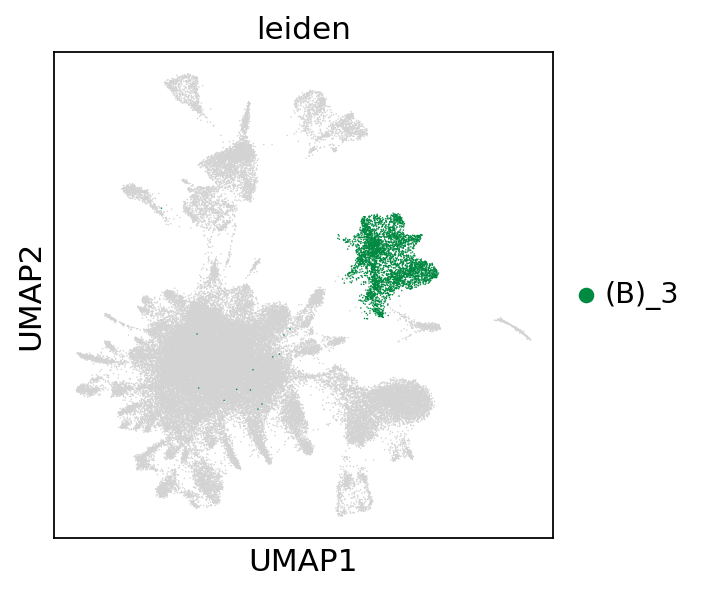

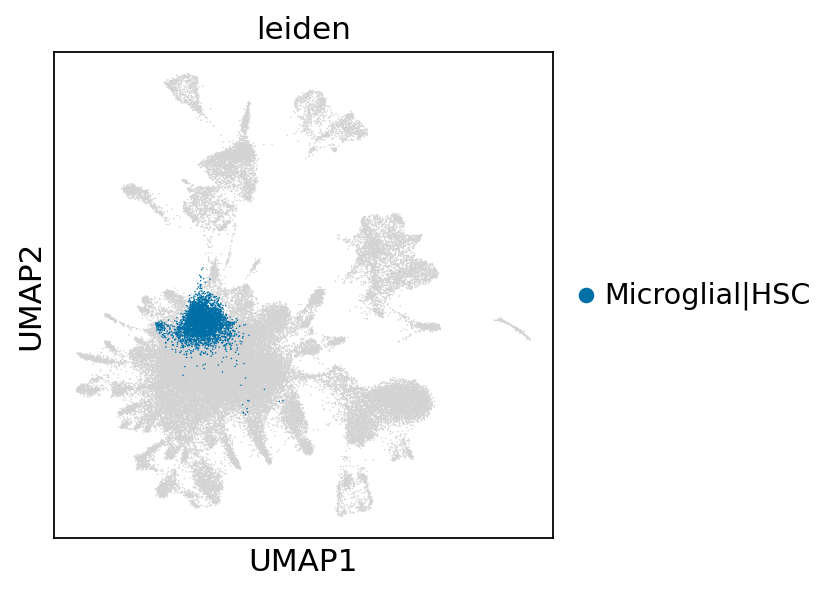

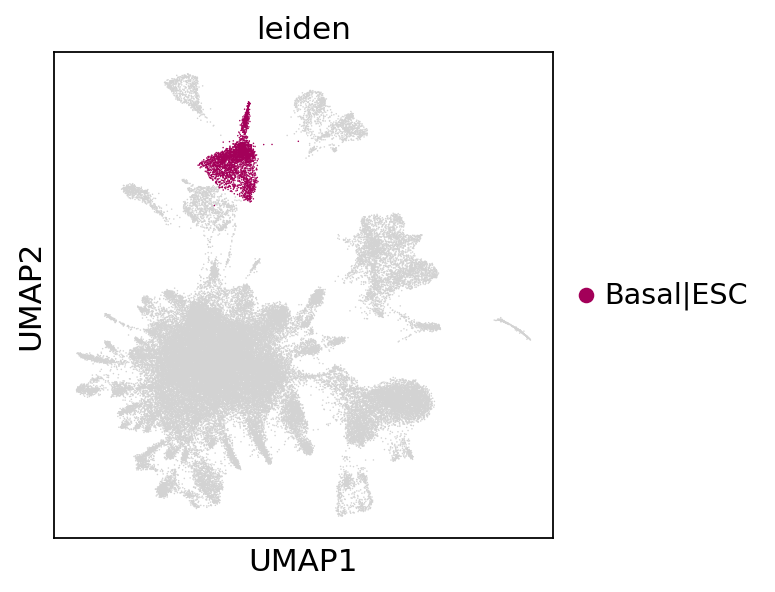

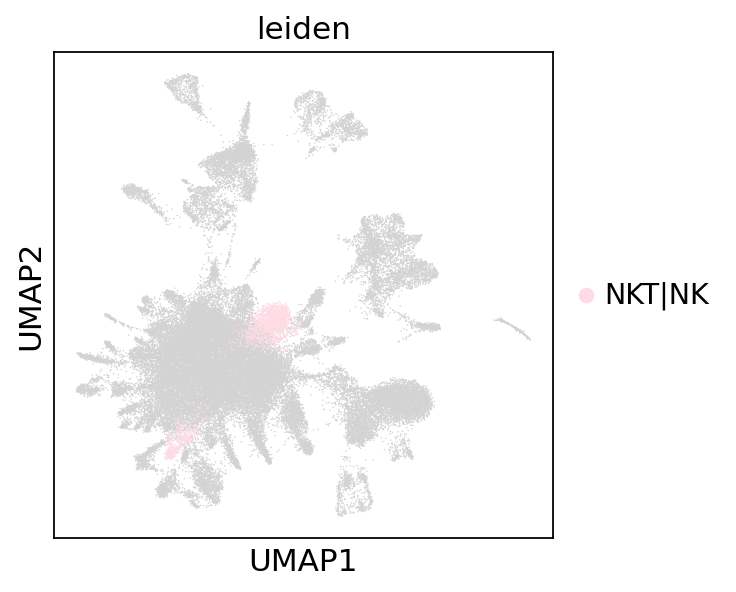

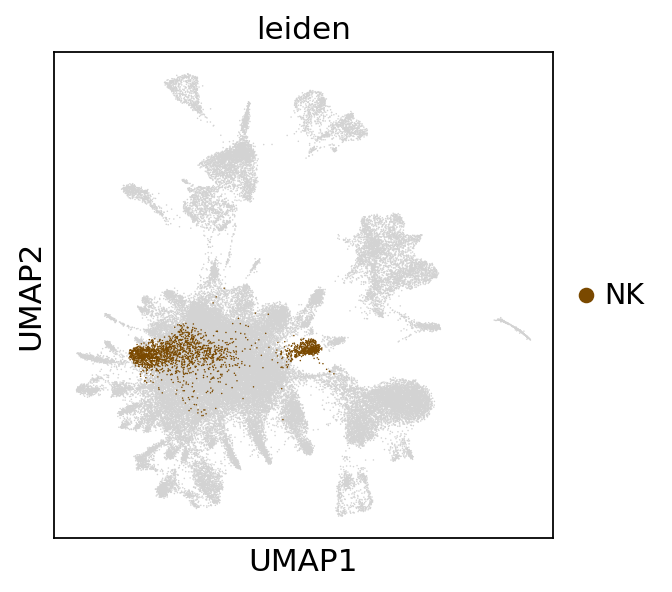

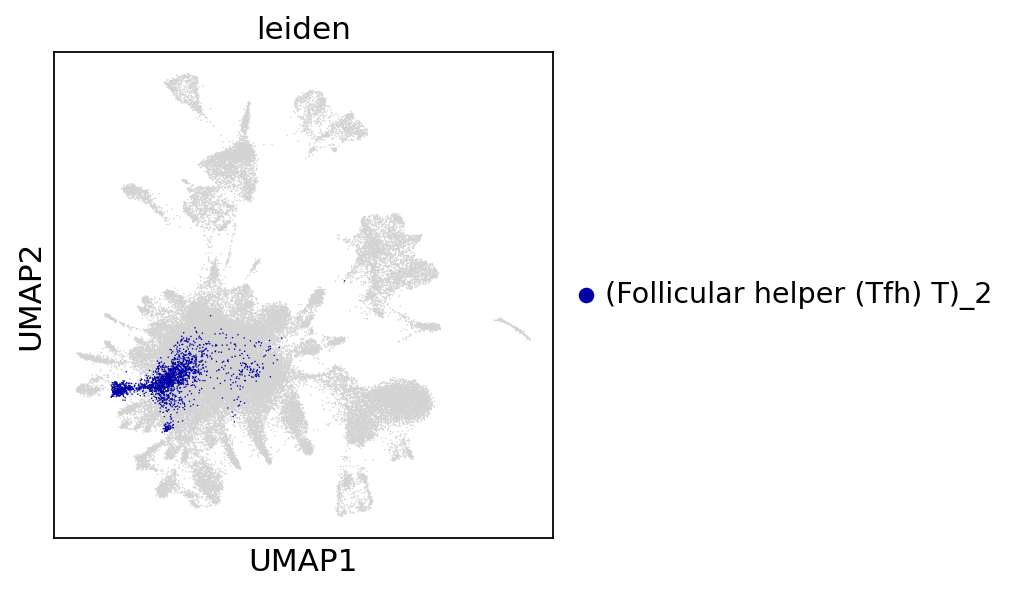

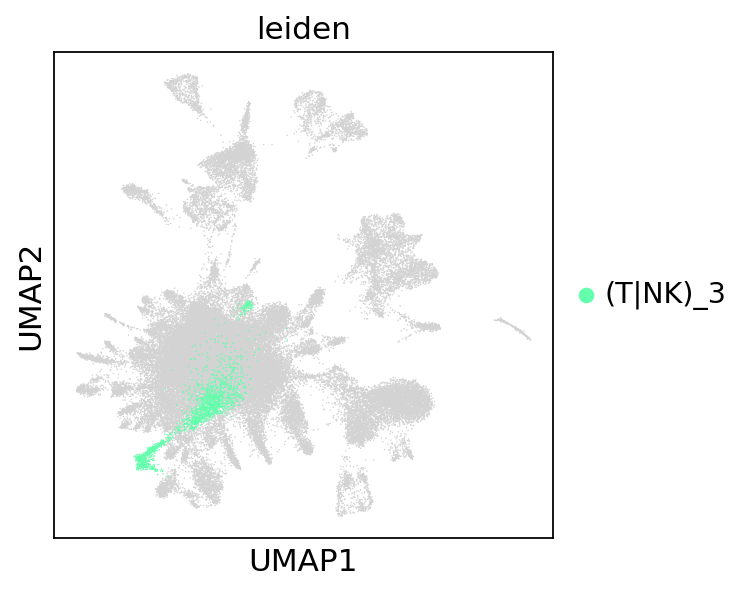

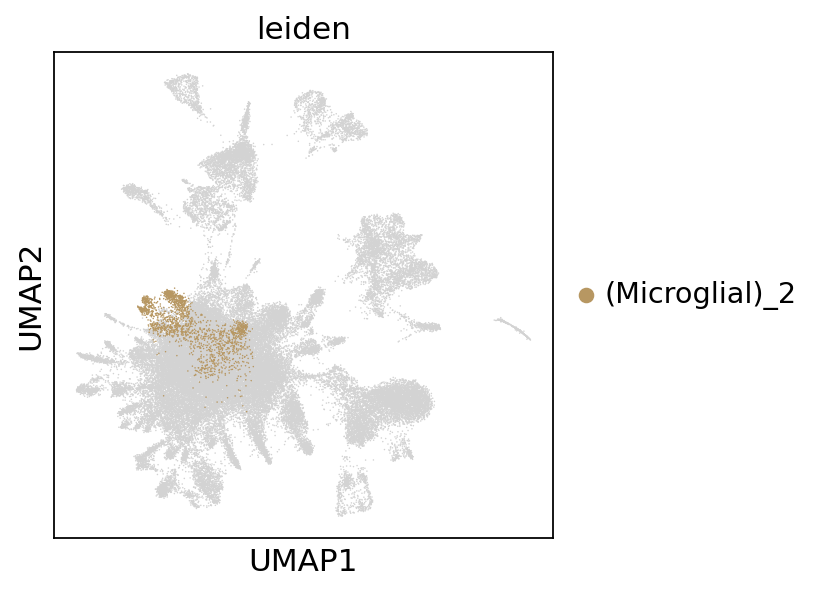

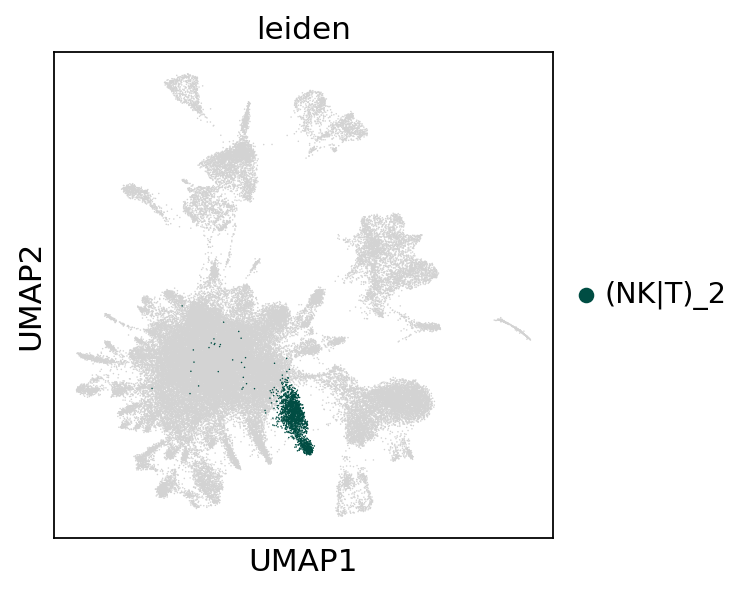

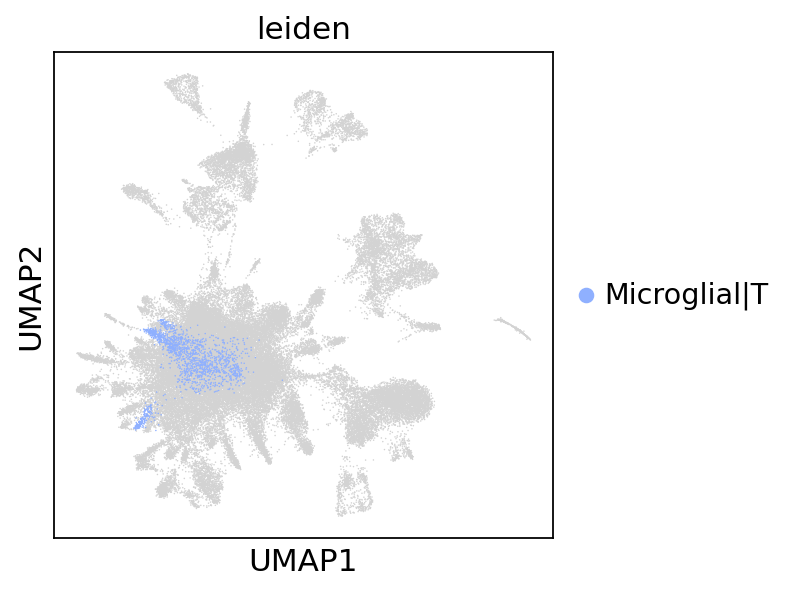

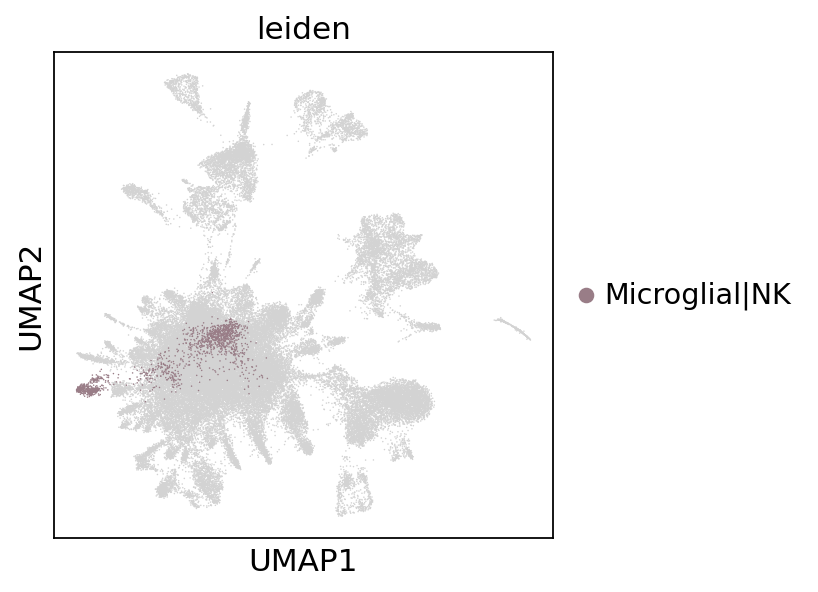

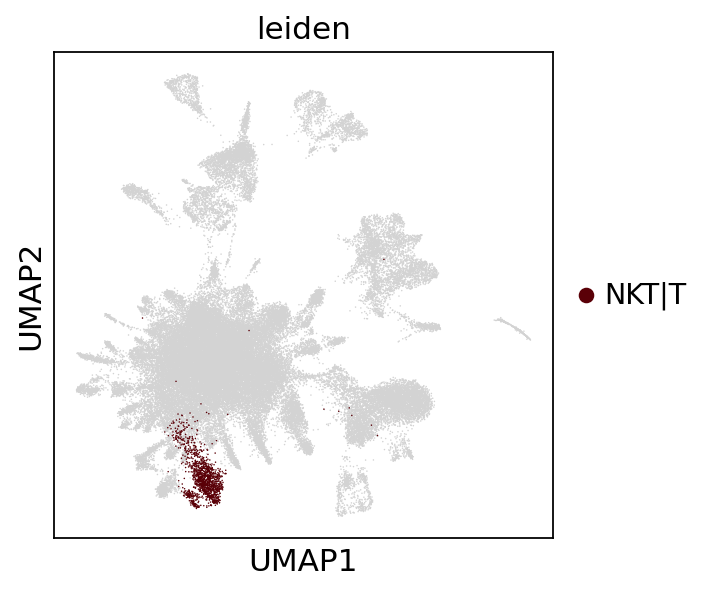

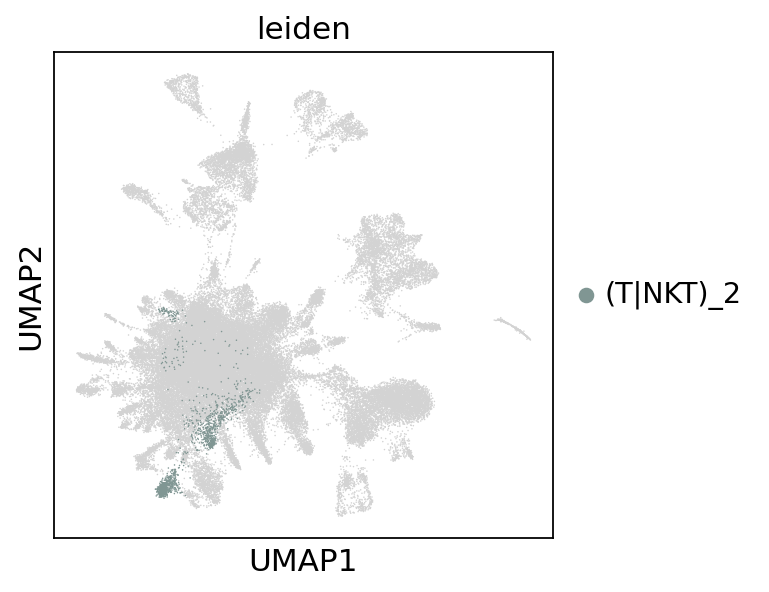

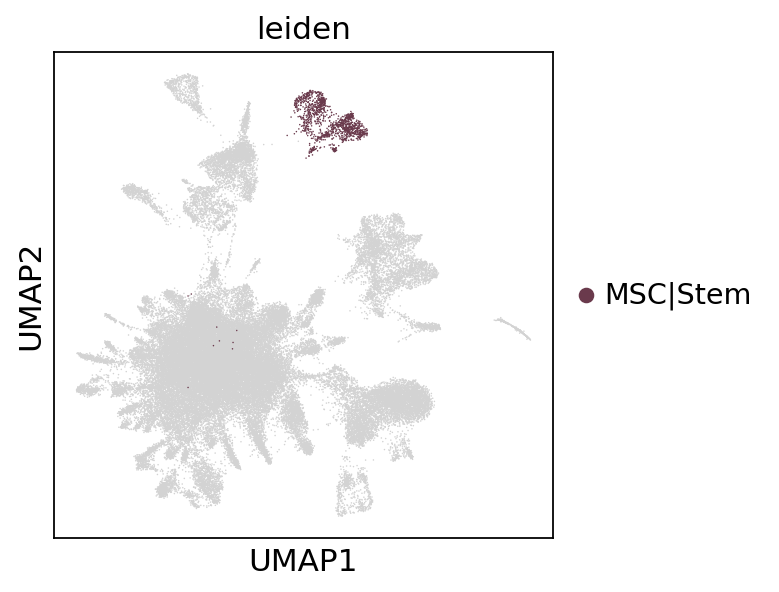

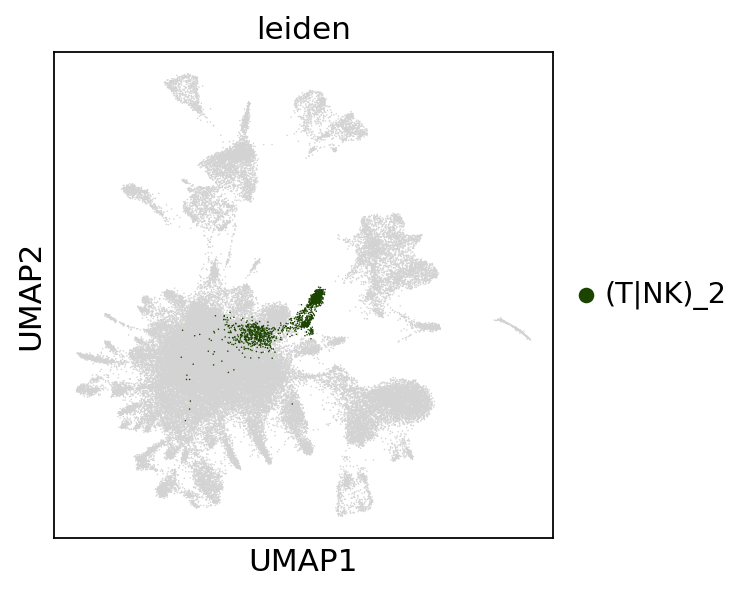

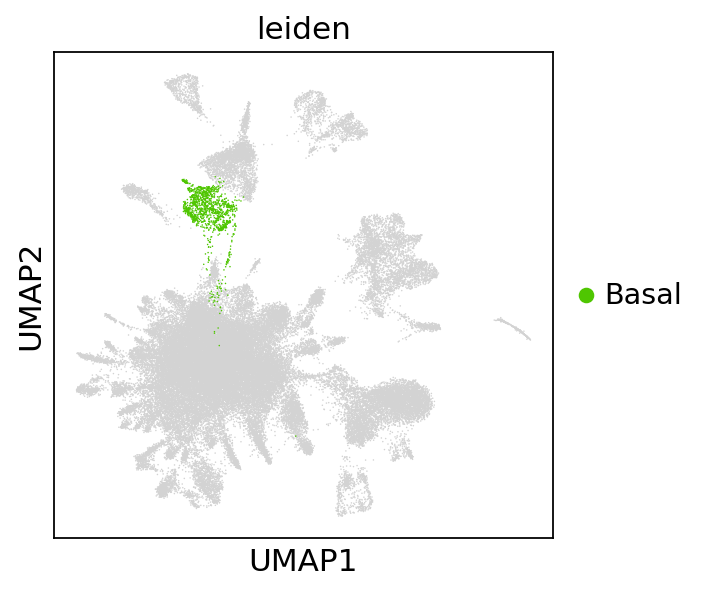

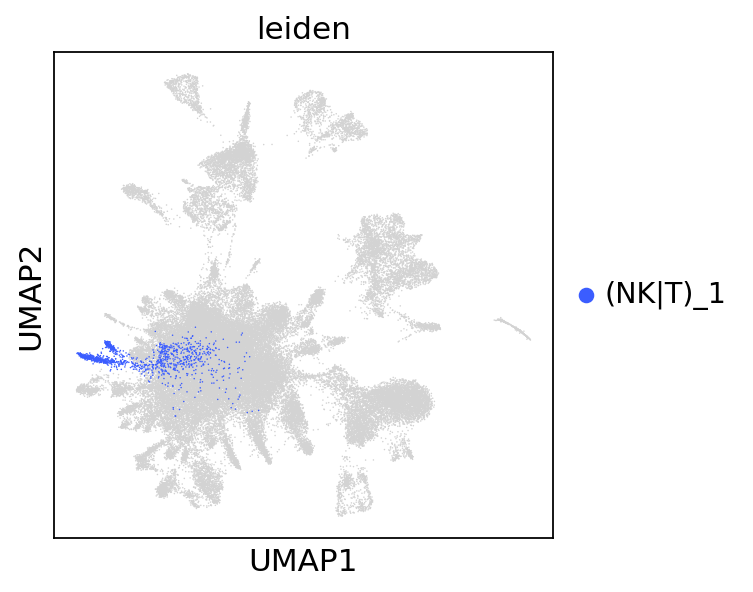

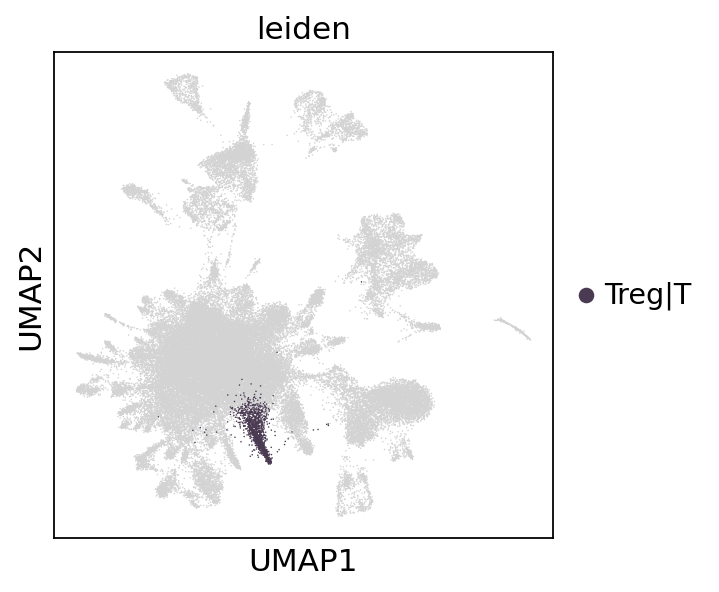

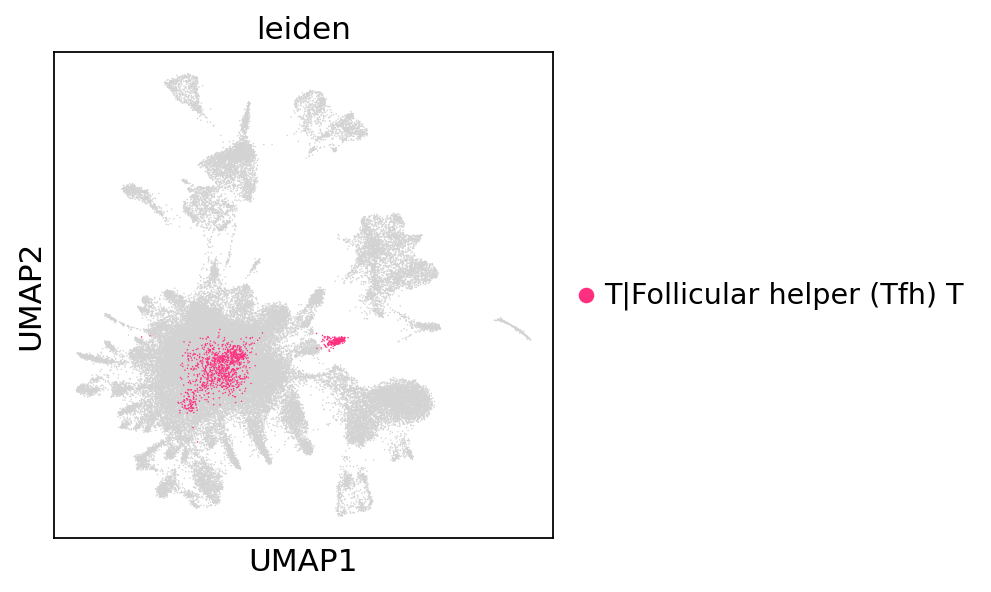

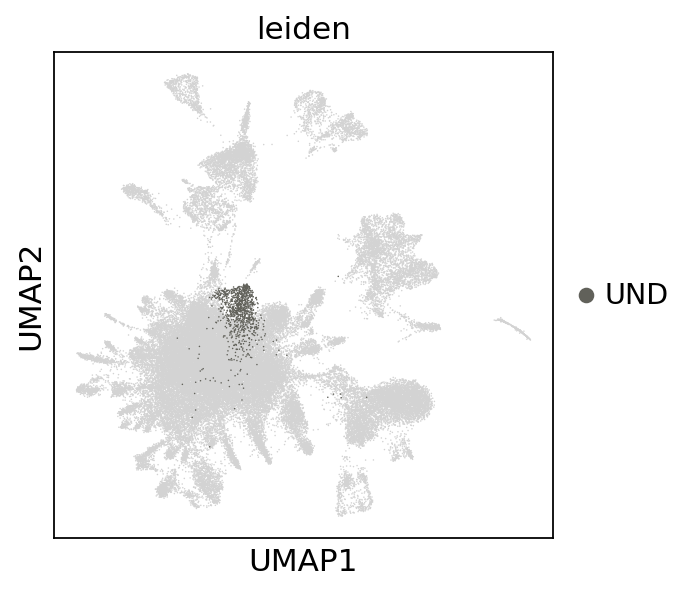

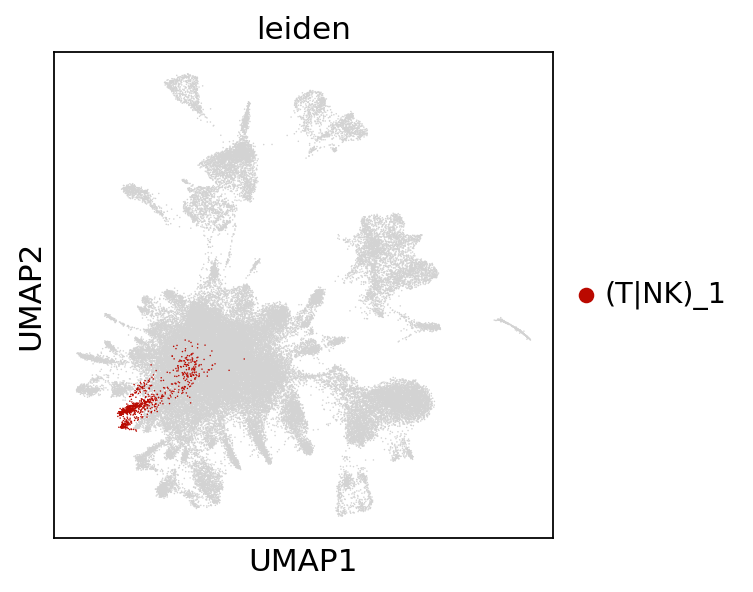

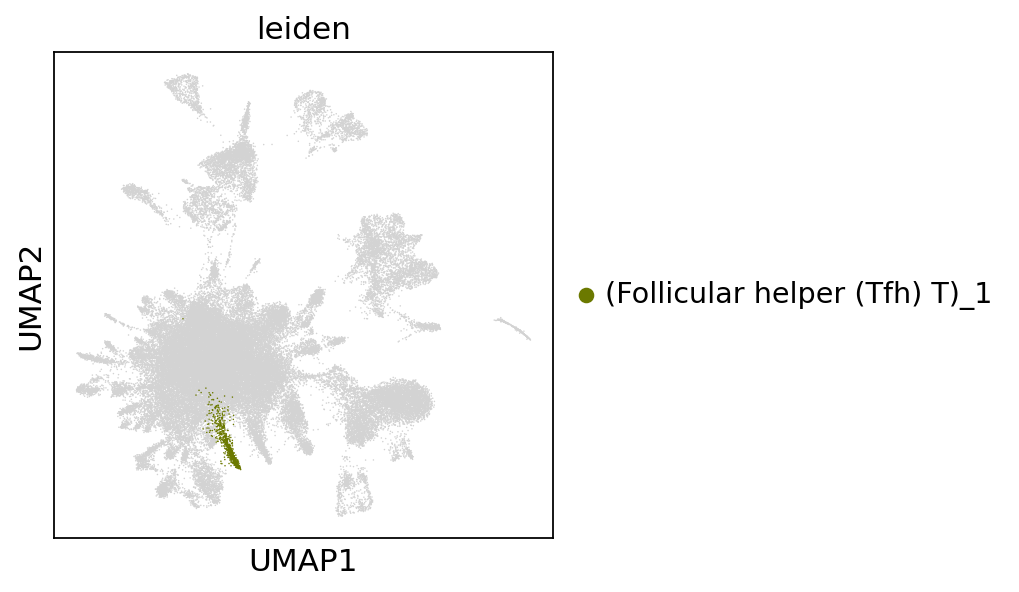

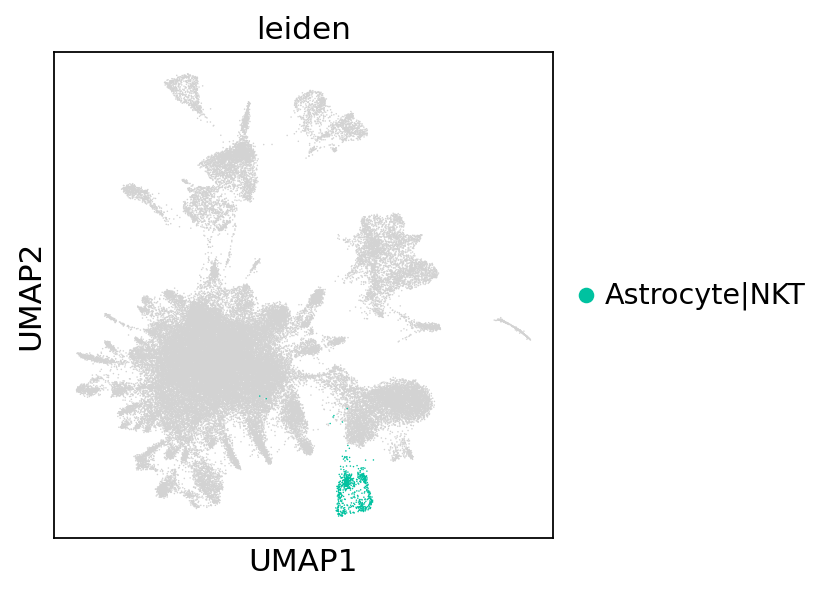

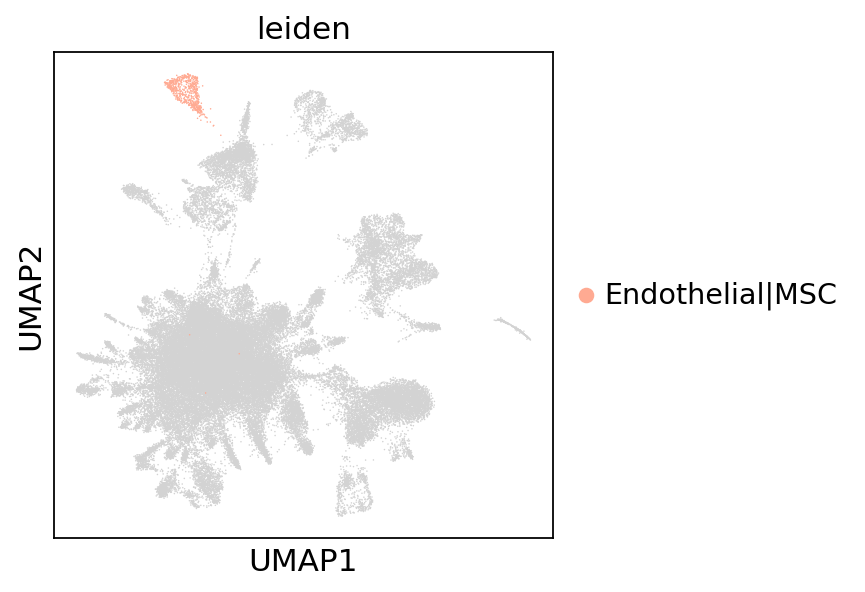

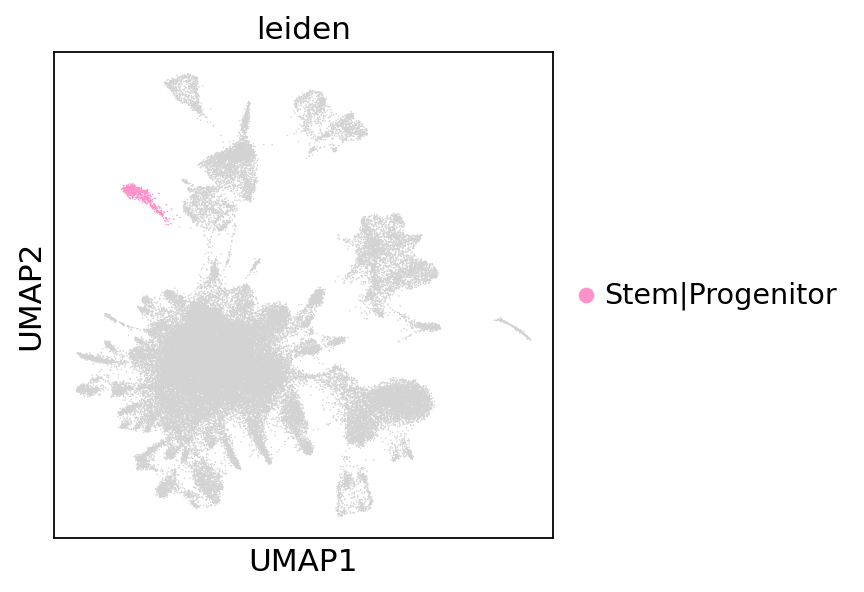

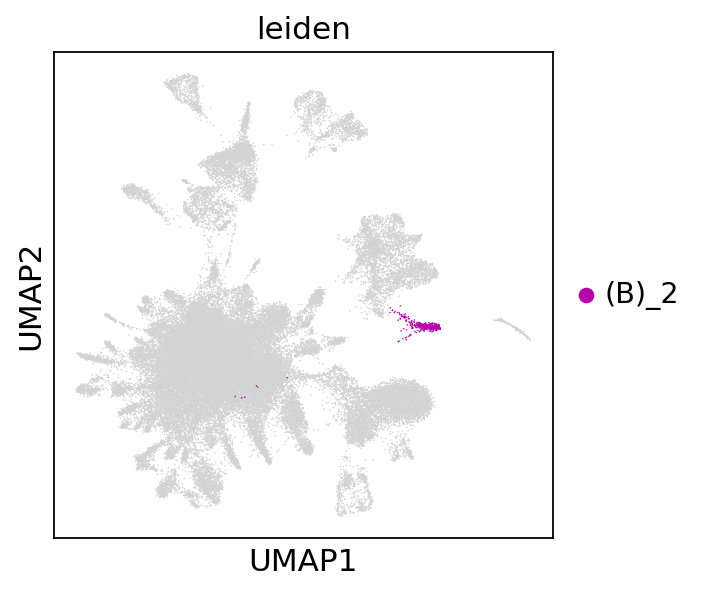

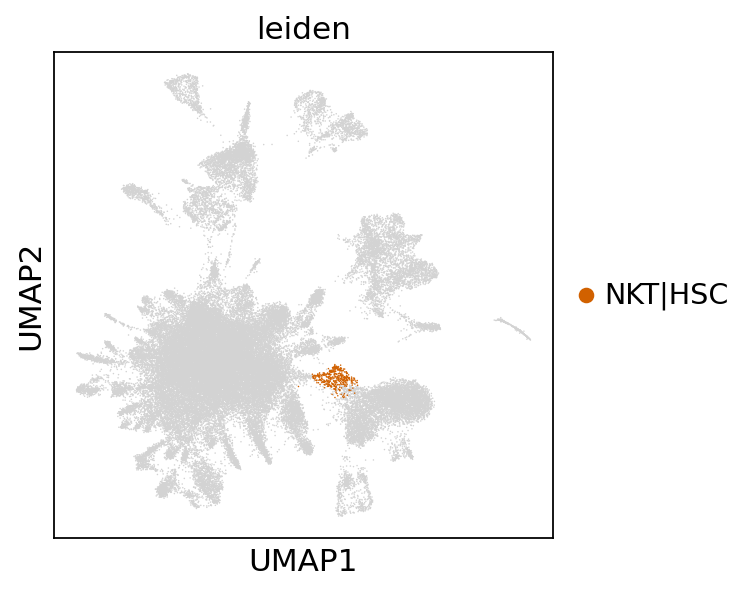

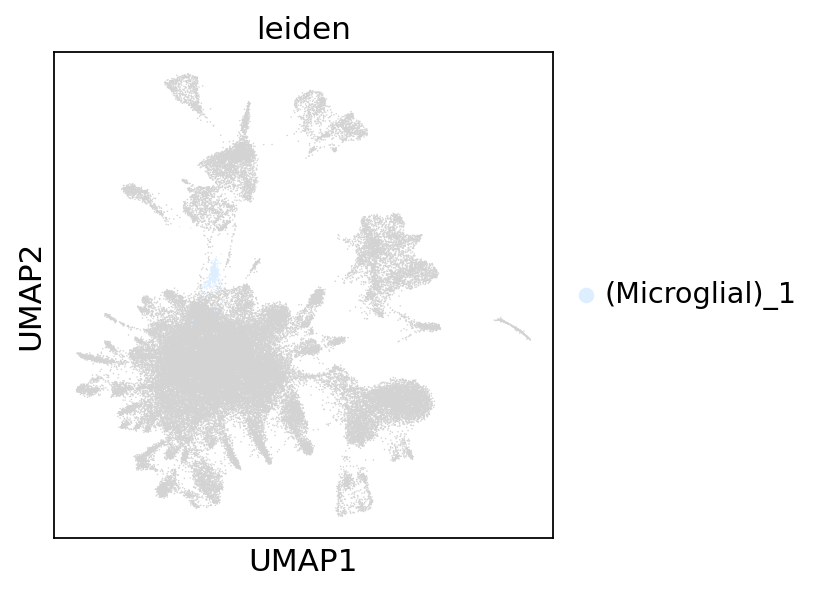

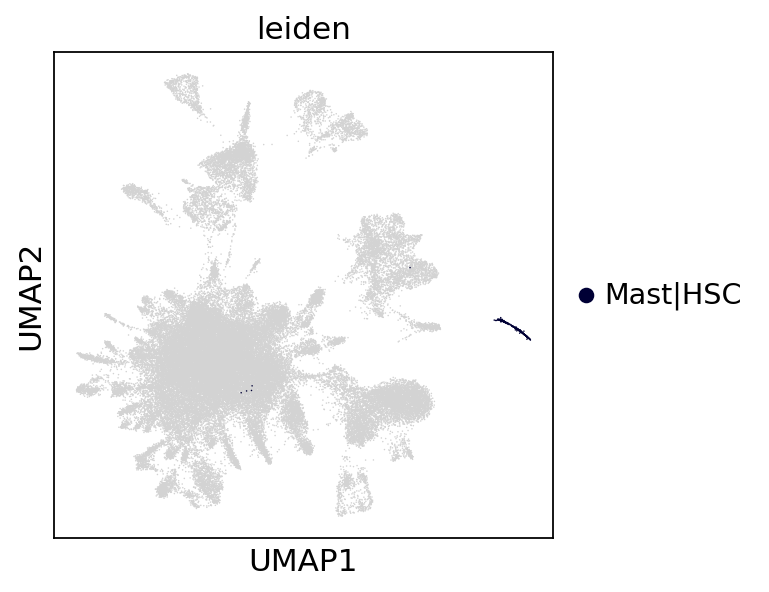

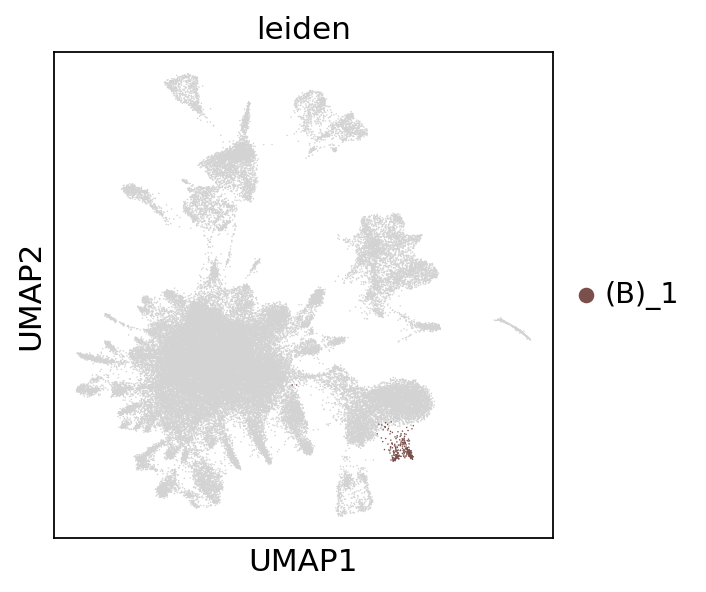

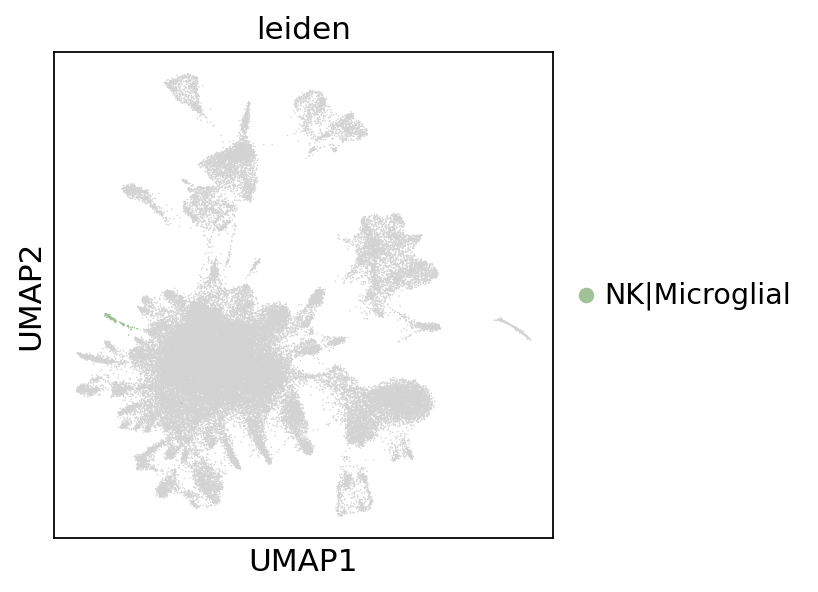

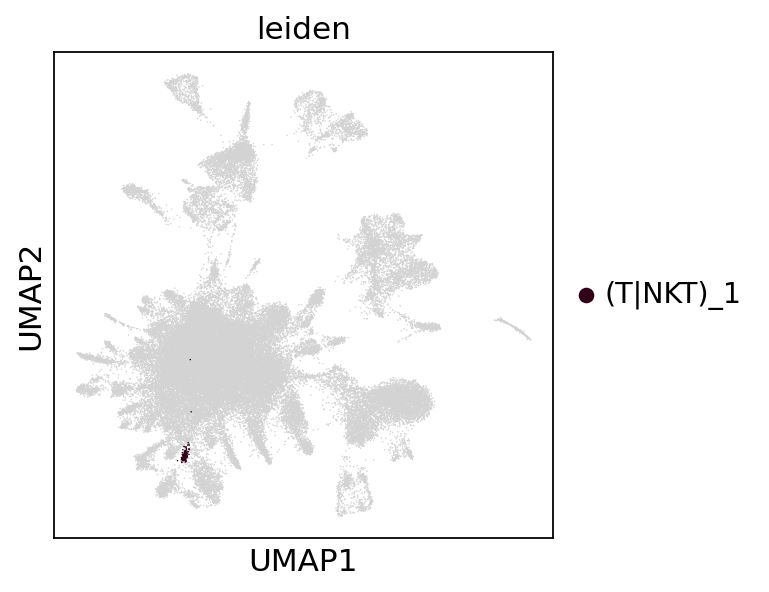

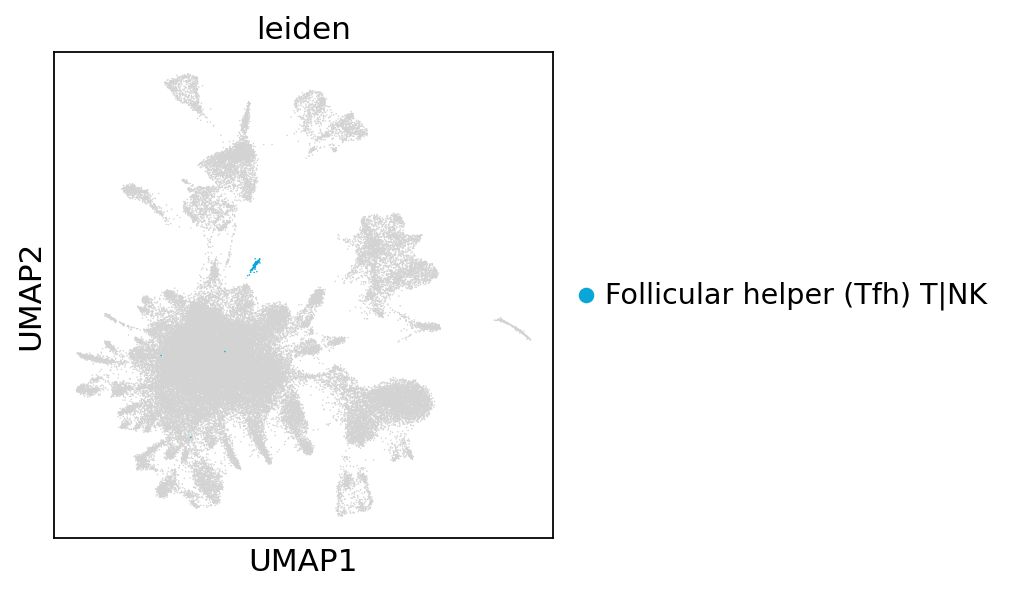

In [11]:
for cluster in umap_cluster_names:
    sc.pl.umap(combined_umap,color='leiden',groups=[cluster])

In [12]:
save_file = '/scratch/combined_umap_annotated.h5ad'
combined_umap.write_h5ad(save_file)